# **FACE EXPRESSION DETECTION**

## **IMPORT LIBRARY**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import copy
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import model_from_json


import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## **TENTUKAN PARAMETER**

In [4]:
pic_size = 48
base_path = "Data\images"
dataset_dir = "Data\images"
batch_size = 128
input_shape = (56, 56, 1)
nb_classes = 7
epochs = 50
model_json_file = ''
model_weights_file = ''

## **TAMPILKAN BEBERAPA GAMBAR UNTUK SETIAP EKSPRESI BERBEDA**

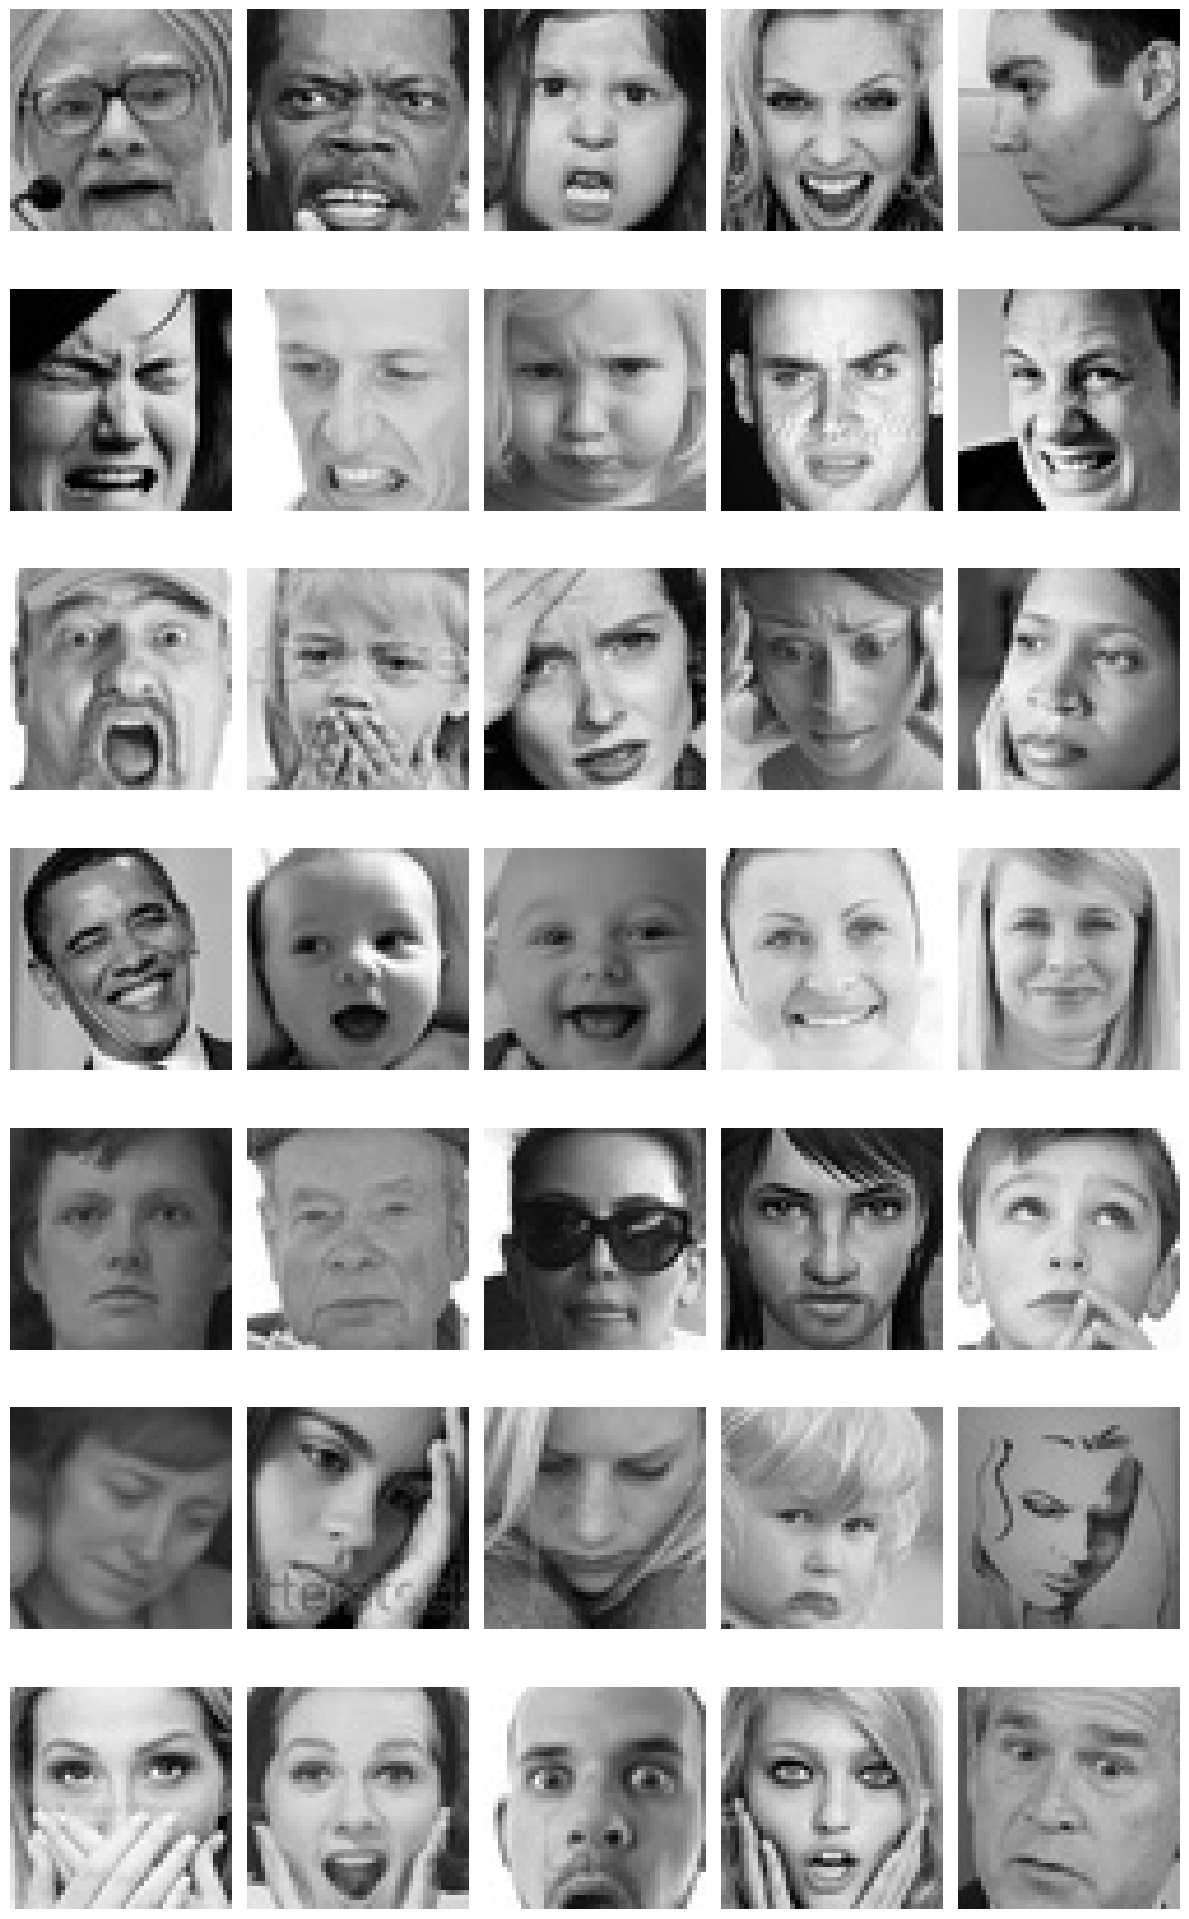

Displaying images from base path: Data\images with picture size: 48


In [3]:
plt.figure(0, figsize=(12, 20))
cpt = 0

train_path = os.path.join(base_path, "train")
if not os.path.exists(train_path):
    print(f"Directory not found: {train_path}")
else:
    for expression in os.listdir(train_path):
        expression_path = os.path.join(train_path, expression)
        if not os.path.isdir(expression_path):
            print(f"Skipping non-directory file: {expression_path}")
            continue
        
        images = os.listdir(expression_path)
        if len(images) < 6:
            print(f"Not enough images in directory: {expression_path}")
            continue

        for i in range(1, 6):
            cpt += 1
            plt.subplot(7, 5, cpt)
            img_path = os.path.join(expression_path, images[i])
            img = load_img(img_path, target_size=(pic_size, pic_size))
            plt.imshow(img, cmap="gray")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

print(f"Displaying images from base path: {base_path} with picture size: {pic_size}")

In [5]:
class_counts = Counter()

# Loop melalui subdirektori dalam dataset_dir
for root, dirs, files in os.walk(dataset_dir):
    for dir_name in dirs:
        class_dir = os.path.join(root, dir_name)
        # Hitung jumlah file di dalam setiap subdirektori kelas
        num_images = len([f for f in os.listdir(class_dir)
                         if os.path.isfile(os.path.join(class_dir, f))])
        # Nama kelas diambil dari nama subdirektori terakhir
        class_name = os.path.basename(class_dir)
        class_counts[class_name] += num_images

# Mendapatkan jumlah masing-masing kelas
class_counts = class_counts

# Menghitung total jumlah kelas dan total jumlah file
num_classes = len(class_counts)
total_file_count = sum(class_counts.values())

# Membuat DataFrame dari hasil penghitungan
class_counts_df = pd.DataFrame.from_dict(
    class_counts, orient='index', columns=['Jumlah'])
class_counts_df.index.name = 'Reaksi'
class_counts_df.reset_index(inplace=True)

# Menampilkan tabel
print(class_counts_df)

# Menampilkan total jumlah kelas dan total jumlah file
print(f"\nTotal Jenis reaksi: {num_classes}")
print(f"Total Jumlah File: {total_file_count}")

       Reaksi  Jumlah
0      images       0
1       train       0
2  validation       0
3       angry    9906
4     disgust    1094
5        fear   10242
6       happy   17978
7     neutral   12396
8         sad   12154
9    surprise    8004

Total Jenis reaksi: 10
Total Jumlah File: 71774


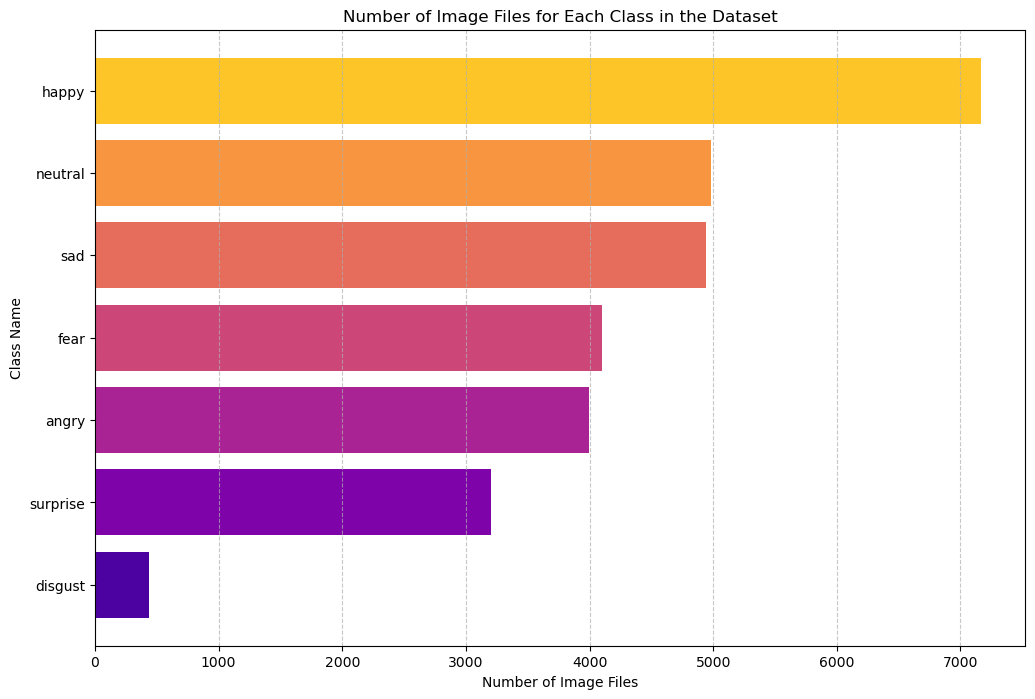

In [6]:
class_counts = {}

for expression in os.listdir(os.path.join(base_path, "train")):
    class_counts[expression] = len(os.listdir(os.path.join(base_path, "train", expression)))

# Mengurutkan kelas berdasarkan jumlah file
sorted_class_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=False)
sorted_class_names = [item[0] for item in sorted_class_counts]
sorted_file_counts = [item[1] for item in sorted_class_counts]

# Setel palet warna berdasarkan jumlah kelas
palette = sns.color_palette("plasma", len(sorted_class_counts))

# Membuat plot
plt.figure(figsize=(12, 8))
plt.barh(sorted_class_names, sorted_file_counts, color=palette)
plt.xlabel('Number of Image Files')
plt.ylabel('Class Name')
plt.title('Number of Image Files for Each Class in the Dataset')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Menampilkan plot
plt.show()

## **DATA AUGMENTASI**

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_path, "train"),
    target_size=(56, 56),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(base_path, "validation"),
    target_size=(56, 56),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


**JUMLAH KELAS DAN LABEL PADA DATA LATIH**

In [8]:
class_indices = train_generator.class_indices
num_classes = len(class_indices)
print(f"Jumlah kelas: {num_classes}")
print("Label kelas:", class_indices)

Jumlah kelas: 7
Label kelas: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


**JUMLAH KELAS DAN LABEL PADA DATA VALIDASI**

In [9]:
class_indices = validation_generator.class_indices
num_classes = len(class_indices)
print(f"Jumlah kelas: {num_classes}")
print("Label kelas:", class_indices)

Jumlah kelas: 7
Label kelas: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


## **MENDEFINISIKAN MODEL CNN**

In [10]:
model = Sequential()

# Lapisan konvolusi pertama
model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Lapisan konvolusi kedua
model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Lapisan konvolusi ketiga
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Lapisan konvolusi keempat
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Perataan
model.add(Flatten())

# Lapisan pertama yang terhubung sepenuhnya
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Lapisan ke-2 yang terhubung sepenuhnya
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Lapisan keluaran
model.add(Dense(nb_classes, activation='softmax'))

**KOMPLIKASI MDOEL**

In [12]:
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

**MELATIH MODEL NYA**

In [13]:
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    callbacks=callbacks_list
)

Epoch 1/50


**CETAK RINGKASAN MODEL**

In [ ]:
print(model.summary())

## **VISUALISASI AKURASI DAN KERUGIAN PELATIHAN DAN PENGUJIAN**

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(24, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'b', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'r', label='Validation Accuracy')
plt.grid(True)
plt.legend()
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'b', label='Training Loss')
plt.plot(epochs_range, val_loss, 'r', label='Validation Loss')
plt.grid(True)
plt.legend()
plt.xlabel('Epoch')

plt.show()

valid_acc = history.history['val_accuracy']
best_epoch = valid_acc.index(max(valid_acc)) + 1
best_acc = max(valid_acc)
print(f'Best Validation Accuracy Score {best_acc:.5f}, is for epoch {best_epoch}')

## **HUBUNGKAN DENGAN OpenCV**

In [ ]:
with open(model_json_file, "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(model_weights_file)

face_cascade = cv2.CascadeClassifier('../input/face-expression-model/haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    img = copy.deepcopy(frame)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    for (x, y, w, h) in faces:
        fc = gray[y:y+h, x:x+w]
        roi = cv2.resize(fc, (48, 48))
        pred = loaded_model.predict(roi[np.newaxis, :, :, np.newaxis])
        text_idx = np.argmax(pred)
        text_list = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
        text = text_list[text_idx]
        cv2.putText(img, text, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 0, 255), 2)
        img = cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)

    cv2.imshow("frame", img)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
